Use this notebook to generate some dake data and send requests to the API.

In [2]:
import http.client
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

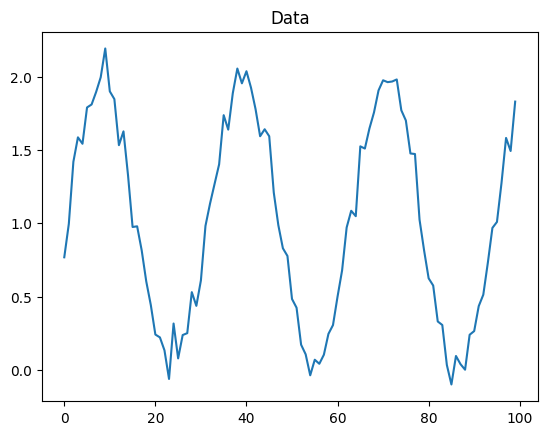

In [27]:
# Generate some data of the form y = a + x + noise, of length n
def generate_linear(n: int, a: float, std: float = 1):
    x = np.arange(n)
    noise = np.random.normal(0, std, n)
    y = a + x + noise
    return x, y


# Generate some data of the form y = a + x**2 + noise, of length n
def generate_exponential(n: int, a: float, std: float = 1):
    x = np.arange(n)
    noise = np.random.normal(0, std, n)
    y = a + x**2 + noise
    return x, y


# Generate some data of the form y = a + sin(x) + noise, of length n
def generate_sin(n: int, a: float, std: float = 1):
    FREQUENCY = 0.2
    x = np.arange(n)
    noise = np.random.normal(0, std, n)
    y = a + np.sin(FREQUENCY * x) + noise
    return x, y


# Generate some data of the form y = a + log(x) + noise, of length n
def generate_log(n: int, a: float, std: float = 1):
    x = np.arange(n)
    x = np.where(x == 0, 1, x)  # Replace all 0s in x with 1s
    noise = np.random.normal(0, std, n)
    y = a + np.log(x) + noise
    return x, y


# _, y = generate_linear(20, 1, 0.5)
# _, y = generate_exponential(100, 1, 100)
_, y = generate_sin(100, 1, 0.1)
# _, y = generate_log(100, 1, 0.3)

# Plot the data
plt.plot(y)
plt.title('Data')
plt.show()


In [86]:
# Run a POST request to the server
payload = {
    'model': 'fast',
    'horizon': 5,
    'series': y.round(2).tolist()
}

payload_json = json.dumps(payload)

# host = 'localhost'
url = 'https://forecast-api-fm46betxta-uc.a.run.app/forecast'
response = requests.post(url, json=payload)
response_json = response.json()
choice_model = response_json['model']
predictions = response_json['predictions']

print(response.status_code, response.reason)


200 OK


In [99]:
import aiohttp
import json
import asyncio

async def make_post_request(url, data):
    async with aiohttp.ClientSession() as session:
        async with session.post(url, json=data) as response:
            return await response.text()


response_text = asyncio.run(make_post_request(url, payload))
print(response_text)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [89]:
import json
import requests
import numpy as np
import asyncio
import time

async def async_make_requests(data_generator, data_params, server_url, horizon, n):
    results = []
    
    for _ in range(n):
        start_time = time.time()
        
        # Generate data using the specified data generator and parameters
        x, y = data_generator(**data_params)
        
        # Prepare the payload for the POST request
        payload = {
            'model': 'fast',
            'horizon': horizon,
            'series': y.round(2).tolist()
        }
        payload_json = json.dumps(payload)
        
        # Make an asynchronous POST request to the server
        async with aiohttp.ClientSession() as session:
            async with session.post(server_url, data=payload_json) as response:
                status_code = response.status
                response_json = await response.json()
                elapsed_time = time.time() - start_time
                
                result = {
                    'status_code': status_code,
                    'elapsed_time': elapsed_time,
                    'parameters': data_params,
                }
                
                results.append(result)
    
    return results

# Example usage:
data_params = {'n': 20, 'a': 1, 'std': 0.5}
server_url = 'https://forecast-api-fm46betxta-uc.a.run.app/forecast'
horizon = 5
n_requests = 10
data_generator = generate_linear

asyncio.run(async_make_requests(data_generator, data_params, server_url, horizon, n_requests))


RuntimeError: asyncio.run() cannot be called from a running event loop

In [57]:
# y = pd.Series(y)
y
pd.concat([y, predictions[:1]], axis=0)

0      1.614426
1      1.991102
2      3.731311
3      4.115618
4      4.843912
5      4.666176
6      6.837318
7      8.559923
8      8.761194
9     10.942523
10    10.101689
11    12.434718
12    12.906261
13    13.603418
14    14.049497
15    15.564753
16    16.971121
17    18.040697
18    19.145007
19    19.643312
20    20.551999
dtype: float64

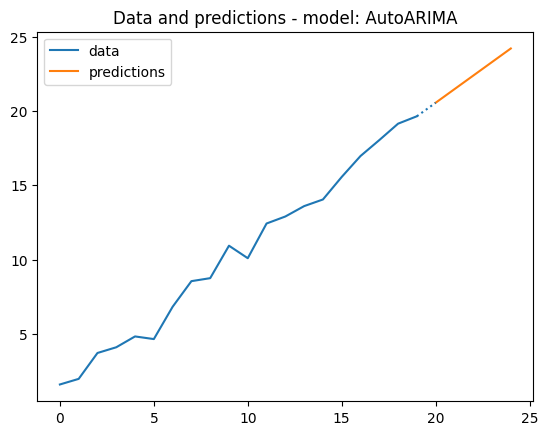

In [82]:
# Reindex the data
y_plot = pd.Series(y)
predictions = pd.Series(predictions, index=np.arange(len(y_plot), len(y_plot) + len(predictions)))

# y_plot = pd.concat([y_plot, predictions[:1]], axis=0)

# Include a vertical line to show where the data ends and the predictions begin
# plt.axvline(predictions.index[0], color='gray', linestyle=':')

bridge = np.array([y.iloc[-1], predictions.iloc[0]])
bridge = pd.Series(bridge, index=[len(y) - 1, len(y)])

# Plot both the data and the predictions (in different colors)
plt.plot(y_plot, label='data', color='tab:blue')

# If there is only one prediction, plot it as a point
if len(predictions) == 1:
    plt.plot(len(y_plot), predictions, 'o', label='prediction')
else:
    plt.plot(predictions, label='predictions', color='tab:orange')

    # Include a marker on the first prediction
    # plt.plot(predictions[:1], 'o', color='tab:orange', markersize=5)

plt.plot(bridge, color='tab:blue', linestyle=':')

plt.legend()


plt.title(f'Data and predictions - model: {choice_model}')
plt.show()


In [65]:
predictions[:1]

20    20.551999
dtype: float64

In [12]:
# Take an e-mail and a project and check if there's an authentication for them for GCP
def check_gcp_auth(email: str, project: str):
    import subprocess
    import json

    def check_account(email: str):
        command = f'gcloud auth list --filter="account:{email}" --format="json"'
        output = subprocess.check_output(command, shell=True)
        output = json.loads(output)

        if output:
            for auth in output:
                if auth['status'] == 'ACTIVE' and auth['account'] == email:
                    return True

        return False

    def check_project(project: str):
        command = 'gcloud config get-value project'
        output = subprocess.check_output(command, shell=True)
        output = output.decode('utf-8').strip()

        if output == project:
            return True

        return False

    account_active = check_account(email)
    if not account_active:
        print(f'Account {email} is not active')
        return False

    project_active = check_project(project)
    if not project_active:
        print(f'Project {project} is not active')
        return False

check_gcp_auth('victoseixasb@gmail.com', 'gcp-experiments')


Account victoseixasb@gmail.com is not active


False

In [39]:
df_logs = pd.read_csv('../logs.csv')

# Only keep logs from after 2024-01-14 23:10:00
df_logs = df_logs[df_logs['method'] == 'POST']
df_logs = df_logs[df_logs['timestamp'] > '2024-01-14 23:27:00']

In [40]:
# df_logs.hist('Time Taken')
# plt.show()

df_logs.sort_values('time_taken', ascending=False).head(10)

,timestamp,method,endpoint,time_taken,data_length,horizon,request_model,response_model
200,2024-01-14 23:28:56,POST,forecast_,53.199301,100,10,cv,ADIDA
281,2024-01-14 23:29:44,POST,forecast_,1.565157,100,10,cv,AutoARIMA
296,2024-01-14 23:29:53,POST,forecast_,1.268438,100,10,cv,AutoARIMA
249,2024-01-14 23:29:26,POST,forecast_,1.185950,100,10,cv,AutoARIMA
264,2024-01-14 23:29:34,POST,forecast_,1.155362,100,10,cv,AutoARIMA
273,2024-01-14 23:29:38,POST,forecast_,1.115975,100,10,cv,AutoARIMA
248,2024-01-14 23:29:24,POST,forecast_,1.087337,100,10,cv,AutoARIMA
220,2024-01-14 23:29:08,POST,forecast_,1.065466,100,10,cv,AutoARIMA
223,2024-01-14 23:29:09,POST,forecast_,1.061858,100,10,cv,AutoARIMA
206,2024-01-14 23:29:00,POST,forecast_,1.015623,100,10,cv,AutoARIMA
